# 3.3 线性回归的简洁实现
本节将介绍如何通过使用适度学习框架简洁地实现3.2节中的线性回归模型。

### 3.3.1 生成数据集

In [33]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [34]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

synthetic是生成合成数据集的函数

### 3.3.2 读取数据集
可以调用框架中的API来读取数据。我们将features和labels作为API的参数传递，并通过数据迭代指定batch_size。此外，布尔值is_train表示是否希望数据迭代器对象在每轮内打乱顺序。

In [35]:
def load_array(data_arrays,batch_size,is_train=True):
    '''构造一个PyTorch数据迭代器'''
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

In [36]:
batch_size = 10
data_iter = load_array((features,labels),batch_size)
next(iter(data_iter))

[tensor([[ 1.0354,  0.7165],
         [ 0.7684, -0.0820],
         [ 0.4048, -0.2048],
         [-0.2931, -0.0239],
         [ 1.4231,  0.7826],
         [-1.7001,  0.8905],
         [-0.7775, -0.2788],
         [-0.5847, -0.3615],
         [-0.4652,  0.6528],
         [ 1.5213, -0.2330]]),
 tensor([[ 3.8448],
         [ 6.0181],
         [ 5.7168],
         [ 3.7006],
         [ 4.3843],
         [-2.2054],
         [ 3.5766],
         [ 4.2645],
         [ 1.0590],
         [ 8.0290]])]

### 3.3.3 定义模型
对于标准深度学习模型，我们可以定义一个模型变量net，它是一个Sequential类的实例。Sequential类为串联在一起的多个层定义了一个容器。当给定输入数据，Sequential实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，依此类推。我们在构造模型时，我们在Sequential实例中传递一个OrderedDict。该OrderedDict中的每个元素将包含一个层的名称（任意），以及层本身。在下面的例子中，我们的线性模型只包含一个全连接层，因此实际上不需要Sequential。但是由于以后几乎所有模型都是多个层的，所以这里使用Sequential来熟悉标准的流程。<br>
回顾3-2中的单层网络架构，这一单层称为<b>全连接层(fully-connected layer)</b>，应为它的每个输入都通过矩阵-向量乘法得到了它的输出。<br>
在pytorch中，全连接层在Linear类中定义。值得注意的是，我们讲两个参数传递到nn.Linear中。第一个参数指定输入特征形状，即2.第二个参数指定输出特征形状，输出特征形状为单个标量，因此为1。

In [37]:
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

### 3.3.4 初始化模型参数
在使用net之前，我们需要初始化模型参数，如在线性回归模型中的权重和偏置。深度学习框架通常有预定义的方法和初始化参数。在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，偏置参数初始化为0。<br>
正如我们在构造nn.Linear是指定输入和输出的尺寸一样，现在我们能直接访问参数以设定它们的初始值。我们通过net[0]选择网络中的第一层，然后使用weight.data和bias.data方法访问参数。我们还可以使用替换方法normal_和fill_来重写参数值。<br>

In [38]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 3.3.5 定义损失函数
计算均方误差使用的是MSLoss类，其也称为平方l<sub>2/</sub>范数。默认情况下，它返回所有样本损失的平均值。

In [39]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法
小批量随机梯度下降算法是一种优化神经网络的标准工具，pytorch在optim模块中实现了该算法的许多变体。当我们实例化一个SGD实例时，我们要指定优化的参数(可通过net.parameters()从我们的模型中获得)以及优化算法所需的超参数字典。小批量随机梯度下降只需要设置lr的值，这里设置为0.03。

In [40]:
trainer = torch.optim.SGD(net.parameters(),lr = 0.03)

### 3.3.7 训练
通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码。我们不必单独分配参数、不必定义我们的损失函数，也不必手动实现小批量随机梯度下降。当我们需要更新更复杂的模型时，高级API的有事讲极大显现。当我们有了所有的基本组件，训练过程的代码与我们从零开始实现时的非常相似。<br>
回顾一下：在每轮里，我们讲完整遍历一次数据集(train_data)，不断从中获取一个小批量的输入和对应的标签。对于每个小批量，我们会执行以下步骤：<br>
&emsp;·通过调用net(x)生成预测并计算损失l(前向传播)<br>
&emsp;·通过进行反向传播来计算梯度<br>
&emsp;·通过调用优化器来更新模型参数<br>
为了更好地衡量训练效果，我们计算每个epoch后的损失，并打印它来监控训练过程。

In [41]:
num_epoch = 3
losses = []
for epoch in range(num_epoch):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    losses.append(l.item())
    print(f'epoch{epoch + 1},loss{l:f}')

epoch1,loss0.000214
epoch2,loss0.000096
epoch3,loss0.000096


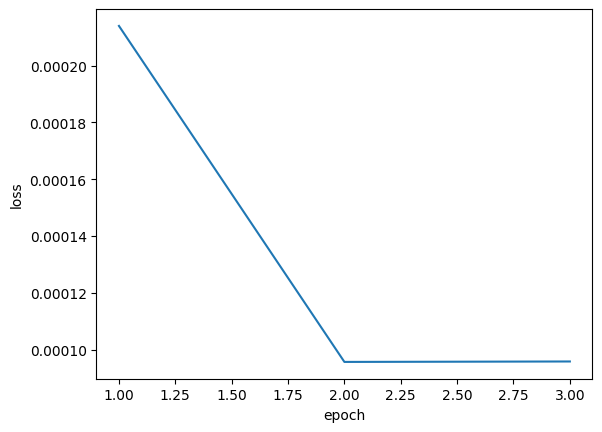

In [42]:
import matplotlib.pyplot as plt
plt.plot(range(1,num_epoch+1),losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

下面我们通过比较生成的真实参数和通过训练得到的模型参数。要访问参数，我们首先从net访问所需的层，然后读取该层的权重和偏置。正如在从零开始实现中那样，我们估计得到的参数和生成数据集的真实参数非常接近。

In [50]:
w = net[0].weight.data
print('w的误差：',true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的误差：',true_b - b)

w的误差： tensor([0.0003, 0.0002])
b的误差： tensor([0.0005])
